In [1]:
from copy import deepcopy
from statistics import stdev
import matplotlib.pyplot as plt
import numpy as np

# progress graphing utility function

In [2]:
def graph_progress(all_costs, all_accuracies, show_recents=True):
    # last 5 results
    # ---------------
    if show_recents:
        line1 = "cost: "
        line2 = "acc:  "
        if len(all_costs) < 5: show = len(all_costs)
        else:                  show = 5
        for i in range(-show, 0):
            line1 += "{:>8} ".format(round(all_costs[i], 5))
            line2 += "{:>8}%".format(round(all_accuracies[i]*100, 2))
        print(line1)
        print(line2)


    # graphs
    # -------
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    axes[0].plot(range(len(all_costs)), all_costs, label="costs")
    axes[0].set_xlabel('step') # Set the y axis label of the current axis.
    axes[0].set_ylabel('cost') # Set a title of the current axes.
    axes[0].set_title('cost over training steps') 
    axes[0].legend() # show a legend on the plot

    axes[1].plot(range(len(all_accuracies)), all_accuracies, label="accuracies")
    axes[1].set_xlabel('step') # Set the y axis label of the current axis.
    axes[1].set_ylabel('accuracy') # Set a title of the current axes.
    axes[1].set_title('accuracy over training steps') 
    axes[1].legend() # show a legend on the plot

    return fig.tight_layout()

<hr>

# import training data

In [3]:
import pandas as pd #1
import os           #3

In [4]:
given_data_folder = '../../data_prep/prepped'

file_names = os.listdir(given_data_folder)
file_names.sort()
file_names

['.DS_Store',
 'M_predictions.csv',
 'M_testing.csv',
 'M_testing_embedding.csv',
 'M_testing_embedding_2023.csv',
 'M_training_data.csv',
 'M_training_data_embedding.csv',
 'M_training_data_embedding_2023.csv',
 'W_predictions.csv',
 'W_testing.csv',
 'W_testing_embedding.csv',
 'W_testing_embedding_2023.csv',
 'W_training_data.csv',
 'W_training_data_embedding.csv',
 'W_training_data_embedding_2023.csv']

In [5]:
training_data_file = 'M_training_data_embedding_2023.csv'

In [6]:
file_path = given_data_folder + '/' + training_data_file 
training_df  = pd.read_csv(file_path)
print(len(training_df))

training_df.head(5)

8680


,team1_id,team2_id,Pts,FG%2,FGA2,FG%3,FGA3,FT%,FTA,OR,...,xFTA_a,xOR_a,xDR_a,xAst_a,xTO_a,xStl_a,xBlk_a,xPF_a,xStr_a,solution
0,11682023.0,14362023.0,0.655,0.637931,0.707547,0.449198,0.611111,0.794118,0.472222,0.558824,...,-0.527778,-0.441176,-0.676471,-0.565217,-0.690476,-0.615385,-0.5625,-0.629630,-0.259983,1
1,14362023.0,11682023.0,0.665,0.735565,0.556604,0.632566,0.569444,0.758333,0.375000,0.205882,...,-0.500000,-0.441176,-0.676471,-0.478261,-0.571429,-0.730769,-0.5000,-0.611111,-0.405813,-1
2,12592023.0,11352023.0,0.655,0.628732,0.688679,0.603199,0.597222,0.585294,0.375000,0.500000,...,-0.402778,-0.500000,-0.735294,-0.695652,-0.500000,-0.538462,-0.2500,-0.611111,-0.186505,1
3,11352023.0,12592023.0,0.665,0.662377,0.773585,0.503268,0.500000,0.652778,0.416667,0.382353,...,-0.291667,-0.264706,-0.794118,-0.673913,-0.714286,-0.500000,-0.2500,-0.425926,-0.334057,-1
4,12802023.0,11152023.0,0.680,0.741012,0.707547,0.609412,0.541667,0.576923,0.361111,0.647059,...,-0.361111,-0.352941,-0.544118,-0.478261,-0.666667,-0.615385,-0.2500,-0.518518,-0.484383,1


## get as rows

In [7]:
# wether or not to keep the data for stats against a team
keep_against = True

In [8]:
training_column_names = training_df.columns.tolist()

# get all data as columns
training_columns = []
for i in range(len(training_column_names)):
    new_column = list(training_df[training_column_names[i]])
    training_columns.append(new_column)
    

    
# indicis
# 30 each 0:15, 15:30, 30:45, 45:60
if not keep_against:
    new_training_columns = training_columns[0:15] + training_columns[30:45] + [training_columns[60]]
    training_columns = new_training_columns
    
    
    
# get as rows
training_input_rows    = []
training_solution_rows = []
embedding_key_rows     = []
for i in range(len(training_columns[0])):
    new_input_row         = []
    new_solution_row      = [training_columns[-1][i]]
    new_embedding_key_row = [int(training_columns[0][i]), int(training_columns[1][i])]
    for j in range(2, len(training_columns)-1):
        new_input_row.append(training_columns[j][i])
        
    training_input_rows   .append(new_input_row)
    training_solution_rows.append(new_solution_row)
    embedding_key_rows    .append(new_embedding_key_row)
    
print(len(training_input_rows), len(training_input_rows[0]))
print(len(training_solution_rows), len(training_solution_rows[0]))
print(len(embedding_key_rows), len(embedding_key_rows[0]))

8680 114
8680 1
8680 2


### formatting and splitting data (only using a limited split of the games to speed up testing)

In [9]:
split = 4_000
np_inputs    = np.array(training_input_rows[:split])
np_solutions = np.array(training_solution_rows[:split])

embedding_key_rows = embedding_key_rows[:split]

#np_inputs    = np.array(training_input_rows)
#np_solutions = np.array(training_solution_rows)

np_data = [np_inputs, np_solutions]

<hr>

# Create and Train population

In [10]:
import sys
sys.path.append("../..")

from network_matrix.population_v3 import Population
from network_matrix.population_v3 import create_embedding

## Choose Model Version

In [11]:
basic = 'Basic'
embeddingWeights = 'Embeddings as WEIGHTS'
embeddingValues  = 'Embeddings as INPUT VALUES'

model = embeddingValues

<hr>

# Creating Embeddings

In [12]:
# Embeddings as INPUT VALUES Version
# ===========================================================
sample_team = 11682023
if model == embeddingValues:
    embedding_length = 50 #75

    unique_team_ids = []
    embeddings_dict = {}
    for i in range(len(embedding_key_rows)):
        row = embedding_key_rows[i]

        for team in row:
            if team not in unique_team_ids:
                unique_team_ids.append(team)
                embeddings_dict[team] = create_embedding(embedding_length, init_range=1.0)

    #print(embeddings_dict[11872022])
    #embedding_key_rows[0] # = [11872022, 14412022]

    
# Embeddings as WEIGHTS Version
# ===========================================================
elif model == embeddingWeights or model == basic: # basic doesn't use embeddings, just creating so no errors
    embedding_length = 75
    num_inputs       = len(np_inputs[0])

    unique_team_ids = []
    embeddings_dict = {}
    for i in range(len(embedding_key_rows)):
        row = embedding_key_rows[i]

        for team in row:
            if team not in unique_team_ids:
                unique_team_ids.append(team)
                embeddings_dict[team] = create_embedding((embedding_length, num_inputs), init_range=0.25)

    #print(embeddings_dict[11872022][0])
    
print('model: {}'.format(model))

model: Embeddings as INPUT VALUES


### checking a sample

In [13]:
if model == embeddingWeights:
    sample_embedding = np.copy(embeddings_dict[sample_team])

    #sample_neuron = list(sample_embedding)
    sample_neuron = list(sample_embedding[0])

    s_average  = 0
    s_abs_avg  = 0
    s_norm_sum = 0

    for weight in sample_neuron:
        s_average  += weight
        s_abs_avg  += abs(weight)
        s_norm_sum += weight

    s_average = (s_average/len(sample_neuron))
    s_abs_avg = (s_abs_avg/len(sample_neuron))

    print("average: {:>6} | abs_avg: {:>6} | sum: {}".format(
        round(s_average,  4), 
        round(s_abs_avg,  4), 
        round(s_norm_sum, 4)
    ))

### misc performance data

In [14]:
'''
learning_rate, steps, batch_size,    cost,      acc,
-------------- ------ ----------- -------- ---------
       0.0001,    50,          2,   0.215,   65.51%,
       
       0.0001     50,          2,   0.190,   71.27%,  # recent 5 games, no stats against
       0.0001    100,          2,   0.188,   71.19%,  # recent 5 games, with stats against
''';

<hr>

# Creating the Model

In [24]:
# Normal Version
# ===========================================================
if model == basic:
    num_inputs = len(np_inputs[0])
    TEST_population  = Population(num_inputs, 1, learning_rate=0.001, embedding_size=int(num_inputs*3/2))

    
# Embeddings as WEIGHTS Version
# ===========================================================
elif model == embeddingWeights:
    num_inputs = len(np_inputs[0])
    TEST_population  = Population(num_inputs, 1, learning_rate=0.0005, embedding_size=(2*embedding_length))

    
# Embeddings as INPUT VALUES Version
# ===========================================================
elif model == embeddingValues:
    num_inputs = len(np_inputs[0]) + (2*embedding_length)
    TEST_population  = Population(num_inputs, 1, learning_rate=0.00001, embedding_size=num_inputs)


# model and number of inputs
print('model: {}'.format(model))
print('----------------------------------')
print('num inputs:   {}'.format(num_inputs))
print('output shape: {}'.format(TEST_population.layers[-1]["weights"].shape))

# values for tracking the models performance
all_times = [0,0,0,0,0]
all_costs = []
all_accuracies = []

model: Embeddings as INPUT VALUES
----------------------------------
num inputs:   214
output shape: (1, 214)


# Training Loops

In [33]:
use_time = True
training_time = 300 # (seconds)
max_steps = 300

In [40]:
# Normal Version
# ===========================================================
if model == basic:
    times, data, costs, accuracies = TEST_population.train_and_test_base(np_inputs, 
                                                                         np_solutions,
                                                                         batch_size=100,
                                                                         steps=max_steps, 
                                                                         training_time=training_time, 
                                                                         use_time=use_time, 
                                                                         report_frequency=1
    )
    

# Embeddings as WEIGHTS Version
# ===========================================================
elif model == embeddingWeights:
    times, data, costs, accuracies = TEST_population.train_and_test_embeddings_WEIGHTS(np_inputs, embedding_key_rows, 
                                                                                       np_solutions, 
                                                                                       embeddings_dict, 
                                                                                       steps=max_steps,
                                                                                       training_time=training_time,
                                                                                       use_time=use_time,
                                                                                       report_frequency=1
    )
    

# Embeddings as INPUT VALUES Version
# ===========================================================
elif model == embeddingValues:
    times, data, costs, accuracies = TEST_population.train_and_test_embeddings(np_inputs, embedding_key_rows, 
                                                                               np_solutions, 
                                                                               embeddings_dict, 
                                                                               steps=max_steps,
                                                                               training_time=training_time,
                                                                               use_time=use_time,
                                                                               report_frequency=1
    )



# update tracking
# ---------------
for i in range(len(all_times)):
    all_times[i] += times[i]
all_costs      += costs
all_accuracies += accuracies

Training Progress:                             |    cost     acc  |     steps           time      remaining  
                                               | --------  ------ | ----------  -------------  ------------- 


model: Embeddings as INPUT VALUES 

 
                  time(s)   percent  per step       | steps:              454
            -------------  --------  --------       | learning rate:    1e-05
set inputs           4.7s      1.57%     0.06       | # connections:   229194
calc value          53.2s     17.68%      0.7       | L1 (sum):           0.0
grad dscnt       2m 45.1s     54.82%     2.17       | L2 (**2):        0.0016
update vals         52.6s     17.49%     0.69
scoring             25.3s      8.39%     0.33       
step time        30m 8.6s     100.0%     23.8

cost:  0.20598  0.20827  0.20764  0.20874   0.2074 
acc:     67.92%   67.42%   67.42%   67.08%   67.58%


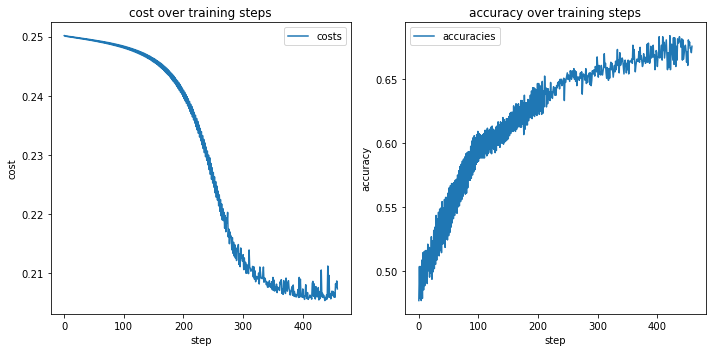

In [44]:
print('model: {} \n'.format(model))
TEST_population.report_training_progress(all_times, data) # timing
graph_progress(all_costs, all_accuracies)                 # graphs
#graph_progress(all_costs[250:], all_accuracies[250:], show_recents=False) # graphs (recent)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<hr>

# Various Status Checks

### Magnitudes of the values of each layer

In [19]:
TEST_population.print_magnitudes_report()


           abs_avg   abs_med       sum       max       min
          --------  --------  --------  --------  --------
values         0.4     0.355    -0.693     0.964    -0.974
biases         0.0       0.0    -0.013     0.003    -0.003
weights      0.027     0.017     9.904     0.224    -0.237
          --------  --------  --------  --------  --------
values       0.185     0.162     4.625     0.574    -0.565
biases         0.0       0.0     0.004     0.003    -0.003
weights      0.027     0.017    -2.857     0.226     -0.22
          --------  --------  --------  --------  --------
values       0.106     0.099    -0.208     0.395    -0.347
biases         0.0       0.0    -0.004     0.001    -0.003
weights      0.027     0.017    10.073     0.247    -0.243
          --------  --------  --------  --------  --------
values       0.064     0.054     -0.84     0.284    -0.218
biases         0.0       0.0     0.002     0.001       0.0
weights      0.027     0.017    -0.488     0.236    -0.

In [20]:
TEST_population.print_magnitudes_report()


           abs_avg   abs_med       sum       max       min
          --------  --------  --------  --------  --------
values         0.4     0.355    -0.693     0.964    -0.974
biases         0.0       0.0    -0.013     0.003    -0.003
weights      0.027     0.017     9.904     0.224    -0.237
          --------  --------  --------  --------  --------
values       0.185     0.162     4.625     0.574    -0.565
biases         0.0       0.0     0.004     0.003    -0.003
weights      0.027     0.017    -2.857     0.226     -0.22
          --------  --------  --------  --------  --------
values       0.106     0.099    -0.208     0.395    -0.347
biases         0.0       0.0    -0.004     0.001    -0.003
weights      0.027     0.017    10.073     0.247    -0.243
          --------  --------  --------  --------  --------
values       0.064     0.054     -0.84     0.284    -0.218
biases         0.0       0.0     0.002     0.001       0.0
weights      0.027     0.017    -0.488     0.236    -0.

### inspect how much an individual embedding changed

In [21]:
#if model == embeddingWeights:
    
new_sample_embedding = np.copy(embeddings_dict[sample_team])

#new_sample_neuron = list(new_sample_embedding)
new_sample_neuron = list(new_sample_embedding[0])

change = 0

average  = 0
abs_avg  = 0
norm_sum = 0

for i in range(len(new_sample_neuron)):
    orig_w = sample_neuron[i]
    weight = new_sample_neuron[i]
    
    average  += weight
    abs_avg  += abs(weight)
    norm_sum += weight
    
    change += (weight-orig_w)
    
average = (average/len(new_sample_neuron))
abs_avg = (abs_avg/len(new_sample_neuron))

change = (change/len(new_sample_neuron))


print("OLD:      average: {:>7} | abs_avg: {:>7} | sum: {}".format(
    round(s_average,  4), 
    round(s_abs_avg,  4), 
    round(s_norm_sum, 4)
))


print("NEW:      average: {:>7} | abs_avg: {:>7} | sum: {}".format(
    round(average,  4), 
    round(abs_avg,  4), 
    round(norm_sum, 4)
))

print("CHANGE:   {}".format(change))


TypeError: 'numpy.float32' object is not iterable

In [ ]:
'''
create embeddings
calculate num inputs
create test population
record values

values:
--------

steps/time
learning rate     - [0.01, 0.001, 0.0001]

embedding size    - [50, 75, 100]
neurons per layer - [1, 1.5, 2]
layers            - [1,2,3]

cost
accuracy

 
 
''';